# Velocity concentration correlation

While this correlation would be a key advancement of active matter science and an important aspect of my paper, it's not yet revealed by my analysis. Today, by watching the PIV overlaid videos again and again, I have two observations:
- high concentration regions (dark regions) usually have small velocity at center
- high concentration regions (dark regions) are usually a center of a swirl (similar to the first observation)
- high concentration regions form from "collisions" between two streams (large negative divergence)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage import io
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
import corrLib
from myImageLib import bpass

## 1. dark regions have small velocity at center

To test this hypothesis, we compare the filtered <del>(gaussian with sigma as correlation length)</del> image with the velocity magnitude field.

- Velocity magnitude correlation

Velocity magnitude correlation length is 14.38 um.


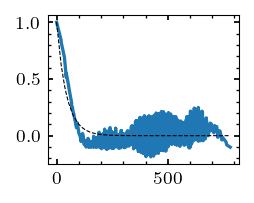

In [31]:
img_folder = r'E:\moreData\08052020\00\8-bit'
piv_folder = r'E:\moreData\08052020\piv_imseq\00'

mpp = 0.33 # um/px
pivData = pd.read_csv(os.path.join(piv_folder, '1882-1883.csv.'))
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
v_2d = {}
for kw in pivData:
    v_2d[kw] = np.array(pivData[kw]).reshape(row, col)
vmag = (v_2d['u'] ** 2 + v_2d['v'] ** 2) ** 0.5
x, y, corrv = corrLib.corrI(v_2d['x'], v_2d['y'], vmag)
corr_r = corrLib.distance_corr(x, y, corrv)
corr_r.R = corr_r.R - corr_r.R.iat[0]
cl, fit = corr_length(corr_r, fitting_range=None)
plt.plot(corr_r.R, corr_r.C)
plt.plot(corr_r.R, exp(corr_r.R, fit[0][0]), color='k', ls='--', lw=0.5)
print('Velocity magnitude correlation length is {:.02f} um.'.format(cl*mpp))

- Velocity correlation

Velocity correlation length is 24.33 um.


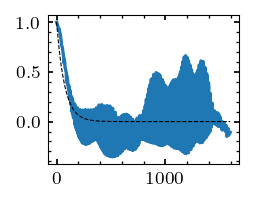

In [33]:
CA, CV = corrLib.corrS(v_2d['x'], v_2d['y'], v_2d['u'], v_2d['v'])

corr_rV = corrLib.distance_corr(v_2d['x'], v_2d['y'], CV)
corr_rV.R = corr_rV.R - corr_rV.R.iat[0]
clV, fitV = corr_length(corr_rV, fitting_range=500)

plt.plot(corr_rV.R, corr_rV.C)
plt.plot(corr_rV.R, exp(corr_rV.R, fitV[0][0]), color='k', ls='--', lw=0.5)
print('Velocity correlation length is {:.02f} um.'.format(clV*mpp))

- Pixel intensity correlation

Pixel intensity correlation length is 28.07 um


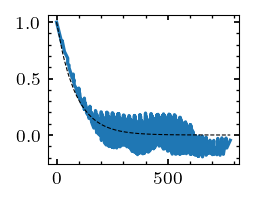

In [109]:
img_raw = io.imread(os.path.join(img_folder, '1882.tif'))
img = bpass(img_raw, 1, 100)
X, Y, I = corrLib.divide_windows(img, windowsize=[25, 25], step=25)
XI, YI, CI = corrLib.corrI(X, Y, I)
corr_rI= corrLib.distance_corr(XI, YI, CI)
corr_rI.R = corr_rI.R - corr_rI.R.iat[0]
clI, fitI = corr_length(corr_rI)
print('Pixel intensity correlation length is {:.02f} um'.format(clI*mpp))
plt.plot(corr_rI.R, corr_rI.C)
plt.plot(corr_rI.R, exp(corr_rI.R, fitI[0][0]), color='k', ls='--', lw=0.5)

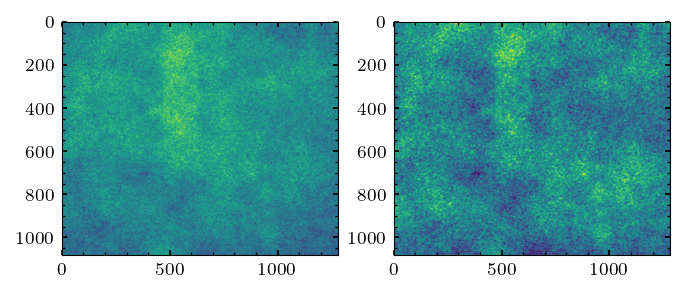

In [108]:
img = bpass(img_raw, 1, 100)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
ax[0].imshow(img_raw)
ax[1].imshow(img)

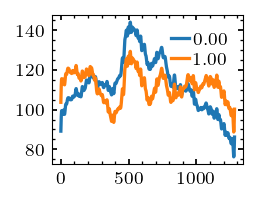

In [110]:
low_bounds = np.linspace(0, 1, 2) # test 10 low bounds ranging from 0 to 3 (Hz)
# profiling from top to bottom
for lb in low_bounds:
    bp = bpass(img_raw, lb, 100)
    plt.plot(bp.mean(axis=0), label='{:.2f}'.format(lb))
plt.legend()

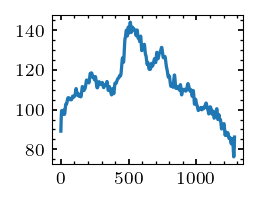

In [80]:
plt.plot(img.mean(axis=0))

#### Comments

I just notice that bpass can significantly modify the pixel intensity correlation lengths I measured. **As I increase the lower frequency bound from 1 to 5 (Hz), the correlation length decreases from 28.07 um to 8.64 um!** A natural question is: what's the proper choice of a bpass lower bound? Or is bpass really need in this analysis? Yes we need bpass because when there is a large spatial illumination inhomogeneity, the correlation function does not look like an exponential decay at all. Then how to choose a bpass lower bound? The idea is that we just want to remove the long range illumination inhomogeneity, but keep all other patterns in the image as much as possible. 

Let's look at an example.



## Background subtraction

Method we use here is "correction from a bright image" according to [The Pantheon project](https://clouard.users.greyc.fr/Pantheon/experiments/illumination-correction/index-en.html). The idea is we average several images (to get rid of details from bacteria and particles, and retain the long range illumination inhomogeneity) to get b(x, y). Use the following transformation to correct the image:
$$ g(x, y) = C\frac{f(x, y)}{b(x, y)} $$
where $f(x, y)$ is the input image and $g(x, y)$ is the corrected image. C is defined as:
$$ C = mean(f(x, y))\frac{1}{mean(\frac{f}{b})} $$

In [157]:
nums = range(1000, 2000)
imgs = {}
for n in nums:
    imgs[str(n)] = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(n)))

In [158]:
# take average to get b(x, y)
for num, kw in enumerate(imgs):
    if num == 0:
        avg = imgs[kw].astype('float64')
    else:
        avg += imgs[kw]
#         print(avg[0, 0])
avg = avg / len(imgs)

In [159]:
# correct images
corrected_imgs = {}
for kw in imgs:
    corrected_imgs[kw] = (imgs[kw] / avg * imgs[kw].mean() / (imgs[kw] / avg).mean()).astype('uint8')    

Text(0.5, 1.0, 'corrected')

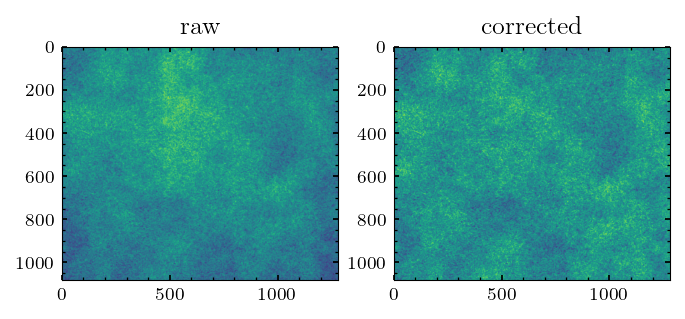

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
ax[0].imshow(imgs['1841'])
ax[0].set_title('raw')
ax[1].imshow(corrected_imgs['1841'])
ax[1].set_title('corrected')

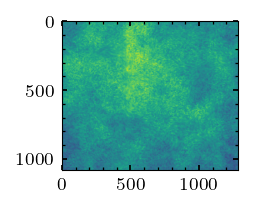

In [153]:
plt.imshow(avg)

In [148]:
corrected_imgs['1841'].min()

93.80252563715239

In [147]:
imgs['1841'].min()

98

Pixel intensity correlation length is 27.33 um


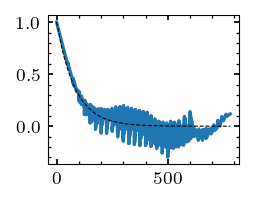

In [161]:
img = corrected_imgs['1841']
X, Y, I = corrLib.divide_windows(img, windowsize=[25, 25], step=25)
XI, YI, CI = corrLib.corrI(X, Y, I)
corr_rI= corrLib.distance_corr(XI, YI, CI)
corr_rI.R = corr_rI.R - corr_rI.R.iat[0]
clI, fitI = corr_length(corr_rI)
print('Pixel intensity correlation length is {:.02f} um'.format(clI*mpp))
plt.plot(corr_rI.R, corr_rI.C)
plt.plot(corr_rI.R, exp(corr_rI.R, fitI[0][0]), color='k', ls='--', lw=0.5)